# **Transformada de Fourier directa e inversa en imágenes**

In [1]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

* Se definen algunas funciones generales necesarias para el desarrollo del trabajo práctico

In [2]:
# +--------------------------------------------------------------------+
# |                       PRODUCTO ENTRE MATRICES                      |
# +--------------------------------------------------------------------+
def apply_matrix(image, matrix):
    """
    Entradas:
        image  -> Array de 3-dimensiones de una imagen RGB 
                  con la forma: (alto, ancho, canales).
                  
        matrix -> Matriz de 3x3 con los valores a operar en 
                  la imagen.
    
    Salida:
        Producto matricial de 'image' y 'matrix' con la forma 
        de 'image'.
    """
    return np.matmul(image.reshape((-1,3)), matrix.T).reshape(image.shape)

# +--------------------------------------------------------------------+
# |                         CONVERSIÓN RGB -> YIQ                      |
# +--------------------------------------------------------------------+
def rgb2yiq(image):
    """
    Entrada: 
        image -> Array de 3-dimensiones de una imagen RGB 
                 con la forma: (alto, ancho, canales).
                 
                 image[..., 0] -> canal R
                 image[..., 1] -> canal G
                 image[..., 2] -> canal B
    
    Salida:
        yiq_image -> Array de 3-dimensiones de la imagen 
                     'image' en el espacio YIQ. 
        
                     yiq_image[..., 0] -> canal Y
                     yiq_image[..., 1] -> canal I
                     yiq_image[..., 2] -> canal Q
    """
    
    rgb2yiq_matrix = np.array([[0.299,       0.587,       0.114],
                               [0.59590059, -0.27455667, -0.32134392],
                               [0.21153661, -0.52273617,  0.31119955]])
    
    if image.max() > 1:
        image = image/255.0
        print("-> Convirtiendo al espacio YIQ...")
        print("   ## Reescalando la imagen en un rango de [0, 1]")
    
    yiq_image = apply_matrix(image, rgb2yiq_matrix)
    
    return yiq_image

# +--------------------------------------------------------------------+
# |                         CONVERSIÓN YIQ -> RGB                      |
# +--------------------------------------------------------------------+
def yiq2rgb(image):
    """
    Entrada: 
        image -> Array de 3-dimensiones de una imagen en el 
                 espacio YIQ con la forma: (alto, ancho, canales).
                 
                 image[..., 0] -> canal Y
                 image[..., 1] -> canal I
                 image[..., 2] -> canal Q
    
    Salida:
        rgb_image -> Array de 3-dimensiones de la imagen 
                     'image' en el espacio RGB. 
        
                     rgb_image[..., 0] -> canal R
                     rgb_image[..., 1] -> canal G
                     rgb_image[..., 2] -> canal B
    """
    
    yiq2rgb_matrix = np.array([[1,  0.9663,  0.6210],
                               [1, -0.2721, -0.6474],
                               [1, -1.1070,  1.7046]])
    
    rgb_image = np.clip(apply_matrix(image, yiq2rgb_matrix), 0, 1)
    
    return rgb_image

def plot_fft(image, magnitude, phase):
    fig, axs = plt.subplots(1, 3, figsize=(15,15))

    axs[0].imshow(image, 'gray')
    axs[0].set_title('Imagen', size=15)
    axs[0].set_axis_off()

    axs[1].imshow(magnitude, 'gray')
    axs[1].set_title('Mágnitud del espectro', size=15)
    axs[1].set_axis_off()

    axs[2].imshow(phase, 'gray')
    axs[2].set_title('Fase del espectro', size=15)
    axs[2].set_axis_off()

    plt.tight_layout()
    plt.show()
    
def rmse(img1, img2):
    return np.sqrt(np.mean((img1-img2)**2))

## 1. Transformada Discreta Rápida de Fourier (FFT)

* Se define una función que permite realizar el cálculo de la FFT de una imagen en blanco y negro de forma $(M, N)$, donde $M$ y $N$ hacen referencia al ancho y alto de la imagen.


* El cálculo de la FFT se entrega con la componente de frecuencia cero desplazada al centro del espectro.

## $$E(F_h, F_v) = \frac{1}{MN}\sum_{m=0}^{M-1}\sum_{n=0}^{N-1} f(n_x,n_y)e^{-2\pi i[\frac{mF_h}{M}+\frac{nF_v}{N}]}$$

In [3]:
def img_fftShift(image):
    """
    Entrada: 
        image -> Array de numpy de una imagen en la escala
                 de grises con la forma: (alto, ancho).
    
    Salida:
        image_magnitude -> Magnitud del espectro para la FFT en el rango [0, 1].
        
        image_phase     -> Fase del espectro para la FFT en el rango [-pi, pi].
    """
    image_ft = np.fft.fftshift(np.fft.fft2(image))
    
    N, M = image.shape
    image_ft = image_ft / (N * M)
    
    image_magnitude = np.abs(image_ft)
    image_phase = np.angle(image_ft)
    
    return image_magnitude, image_phase

## **2. Transformación logarítmica** 

* Se debe tener en cuenta que los coeficientes de la magnitud en la FFT poseen valores pequeños para el rango de una imagen (entre 0 y 255). Además, el 5% de sus compenentes almacenan el 95% de información de la imagen procesada. 


* Teniendo en cuenta lo anterior, se define una función que transforme los valores de magnitud a una escala logarítmica para poder visualizar el espectro.


* La expresión matemática utilizada para la transformación es la siguiente:

## $$\text{I}_{m[log]}=log_{10}(\alpha + I_m\beta)$$

Donde $I_m$, es la magnitud de la FFT de la imagen procesada; $\alpha, \beta$, son constantes reales y $\text{I}_{m[log]}$, es el módulo del espectro en escala logarítmica.

In [4]:
def log_transform(image_magnitude, alpha=0, beta=1):
    """
    Entrada: 
        image_magnitude -> Magnitud de una FFT de una imagen.
        
        alpha, beta     -> Valores enteros para la transformación logarítmica.
    
    Salida:
        Magnitud de la FFT en escala logarítmica.
    """
    return np.log10(alpha + image_magnitude * beta)

## **3. Lectura de imagen y guardado de su espectro**

* Ahora se define una función que permita leer la imagen que se desee procesar y devuelva una variable de tipo np.ndarray de la forma (ancho, alto)


* También se incluye una función que permite guardar la fase y magnitud del espectro procesado en una ubicación específica.

In [5]:
def load_image(path, max_value = 1):
    """
    Entradas:
        path      -> String con la ubicación y nombre del archivo
        max_value -> Entero con el rango de valores de la imagen:
                        1: rango [0, 1]
                        255: rango [0, 255]
    Salida:
        np.ndarray de la imagen ubicada en 'path' con la forma (Ancho, Alto)
        en el rango según 'max_value'
    """
    # Convierte los valores de la imagen al rango [0, 1]
    image = np.array(imageio.imread(path)) / 255.0
    
    # Imagen en formato RGB o RGBA
    if image.ndim > 2:
        image = image[..., 0:3]
        image_gray = rgb2yiq(image)[:,:,0]
    
    # Imagen en blanco y negro
    else:
        image_gray = image
    
    return image_gray if max_value == 1 else (image_gray * 255)

def save_fft(file, path, extension, is_phase):
    """
    Entradas:
        file      -> np.ndarray de forma (Ancho, Alto) en el rango [0, 255]
        path      -> String con la ubicación y nombre de la imagen
        extension -> String con la extensión de la nueva imagen
        is_phase  -> Valor de tipo Bool indicando si 'file' es la fase del espectro
        
    Acción:
        Guarda el archivo 'file' en una imagen.
    
    Salida:
        String con la ubicación y nombre del nuevo archivo. Si es la fase, se le anexa '_fft-P'
        al nombre ingresado por 'path', en caso contrario se añade '_fft-M'. Ejemplo:
        
                 path = ".../imagen1.jpg"
             is_phase =  True
            extension = "bmp"
            
               Salida = ".../imagen1_fft-P.bmp"
            
    """
    file_name, file_extension = os.path.splitext(path)
    
    fft_part = '_fft-P.' if is_phase else '_fft-M.'
    
    new_file_name = file_name + fft_part + extension
    
    new_path = os.path.join(os.getcwd(), new_file_name)

    imageio.imwrite(new_path, file.astype('uint8'))
    
    return new_file_name

## **4. Visualización de la FFT**

* Se procede a calcular y visualizar el espectro de una imagen elegida.

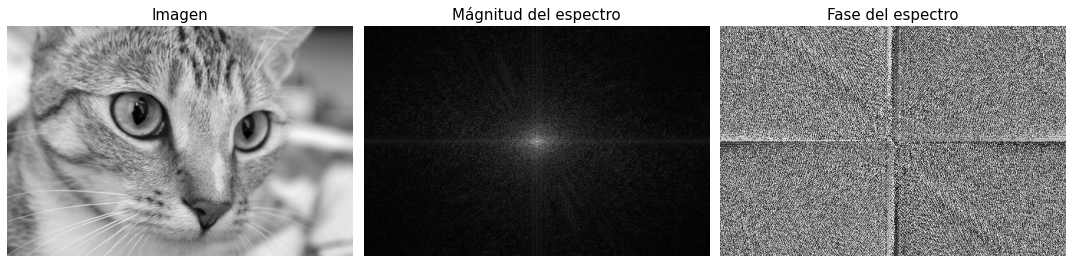

In [11]:
# Imagen a procesar
FILE_PATH = 'docs/chelsea.png'
img_gray = load_image(FILE_PATH)

# Transformada rápida de Fourier (FFT)
Im, Ip = img_fftShift(img_gray)

# Transformación logarítmica para la magnitud
alpha = 1
beta = 10e3
Im_log = log_transform(Im, alpha=alpha, beta=beta)

# Escala la magnitud al rango [0, 255]
Im_log_max = np.log10(alpha + beta)
Im_log_scaled = Im_log * (255.0 / Im_log_max)

# Escala la fase al rango [0, 255]
Ip_scaled = (Ip + np.pi) * 255.0/(2*np.pi)

# Se guarda como imagen la magnitud y fase del espectro
magnitude_file = save_fft(Im_log_scaled, FILE_PATH, 'png', is_phase = False)
phase_file = save_fft(Ip_scaled, FILE_PATH, 'png', is_phase = True)

# Visualización
plot_fft(img_gray, Im_log_scaled, Ip_scaled)

## **5. Transformada logarítmica inversa**

* Para lograr la reconstrucción de la imagen a partir de su espectro guardado en imagen, se requiere realizar el flujo de trabajo inverso al visto previamente.


* Primero se define una transformada que permite tomar la magnitud del espectro en escala logarítmica y retornar sus valores originales. 


* Según la transformada planteada, su inversa está dada por la siguiente expresión:

## $$I_m=\frac{10^{I_{m[log]} - \alpha}}{\beta}$$

In [7]:
def ilog_transform(image_magnitude_log, alpha=0, beta=1):
    """
    Entrada: 
        image_magnitude_log -> Magnitud en escala logarítmica del espectro de una imagen.
        
        alpha, beta         -> Valores enteros para la transformación inversa logarítmica.
    
    Salida:
        Magnitud de la FFT.
    """
    return (10**image_magnitude_log - alpha) / beta

## **6. Transformada rápida de Fourier inversa**

* Ahora se define una función que permita calcular la FFT inversa con la componente de frecuencia cero centrada.

In [8]:
def img_ifftShift(magnitude, phase, image_shape):
    
    # Espectro reconstruido
    N, M = image_shape
    spectrum = magnitude * np.exp(1j * phase)
    spectrum = spectrum * N * M

    # Imagen reconstruida
    image_back = np.fft.ifft2(np.fft.ifftshift(spectrum))
    
    return np.abs(image_back)

## **7. Imagen reconstruida**

* Se reconstruye la imagen inicial a partir del espectro guardado como imagen. Adicional, se compara la reconstrucción con la imagen original para obtener un parámetro de calidad.

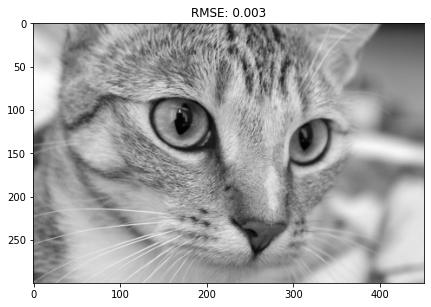

In [12]:
# Carga magnitud y fase del espectro en el rango [0, 255]
IIm_log_scaled = load_image(magnitude_file, 255)
IIp_scaled = load_image(phase_file, 255)

# Escala inversa de la fase
IIp = (IIp_scaled * (2*np.pi) / 255.0) - np.pi

# Escala inversa en la magnitud
IIm_log_max = np.log10(alpha + beta)
IIm_log = IIm_log_scaled * (IIm_log_max / 255.0)

# Transoformación logarítmica inversa
IIm = ilog_transform(IIm_log, alpha, beta)

# Transformada de Fourier inversa
img_back = img_ifftShift(IIm, IIp, IIm_log_scaled.shape)

# Parámetro de calidad de la reconstrucción
img_rmse = round(rmse(img_gray, img_back), 4)

plt.figure(figsize=(7,7))
plt.title('RMSE: {0:.3f}'.format(img_rmse))
plt.imshow(img_back, 'gray')
plt.show()

## **8. Imagen con ruido**

* A continuación, se realiza el mismo procedimiento anterior pero con una imagen con interferencia aditiva.

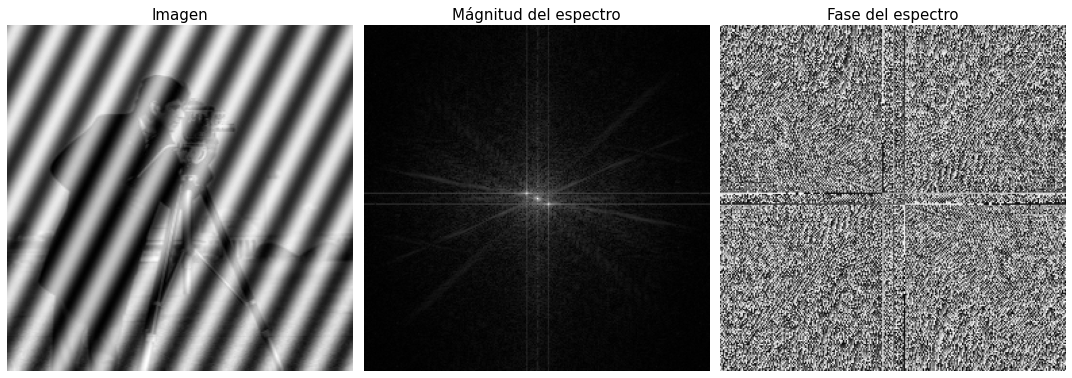

In [19]:
# Imagen a procesar
FILE_PATH = 'docs/tp4.png'
img_gray = load_image(FILE_PATH)

Im, Ip = img_fftShift(img_gray)

Im_log = log_transform(Im, alpha=alpha, beta=beta)
Im_log_max = np.log10(alpha + beta)
Im_log_scaled = Im_log * (255.0 / Im_log_max)

Ip_scaled = (Ip + np.pi) * 255.0/(2*np.pi)

magnitude_file = save_fft(Im_log_scaled, FILE_PATH, 'png', is_phase = False)
phase_file = save_fft(Ip_scaled, FILE_PATH, 'png', is_phase = True)

# Visualización
plot_fft(img_gray, Im_log_scaled, Ip_scaled)

* Como se observa, en la magnitud de la imagen se aprecian tres puntos: el primero de ellos, ubicado en el centro, muestra las componentes de baja frecuencia del espectro con alta información de la imagen; luego, se visualizan dos puntos simétricos entre sí, esto muestra la interferencia vista en la imagen.


* Se procede a modificar el espectro (con un editor de imágenes como Paint) y eliminar la energía de los dos puntos simétricos.

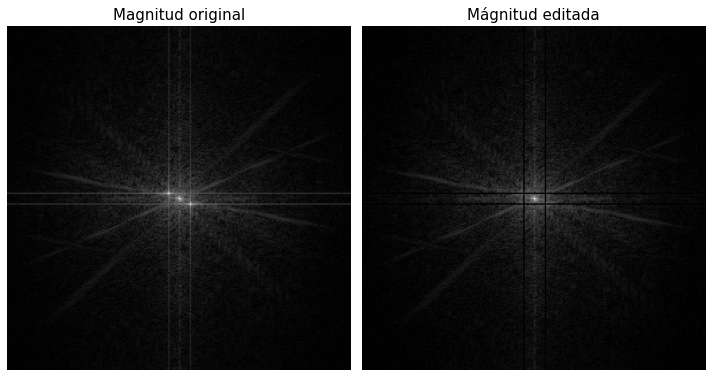

In [24]:
magnitude_modified = load_image(magnitude_file)

fig, axs = plt.subplots(1, 2, figsize=(10,10))

axs[0].imshow(Im_log_scaled, 'gray')
axs[0].set_title('Magnitud original', size=15)
axs[0].set_axis_off()

axs[1].imshow(magnitude_modified, 'gray')
axs[1].set_title('Mágnitud editada', size=15)
axs[1].set_axis_off()

plt.tight_layout()
plt.show()

* Nótese que los dos puntos simétricos se taparon con dos cruces de color negros, es decir, los valores de energía en esa posición se anulan.


* Ahora se reconstruye la imagen para ver el resultado.

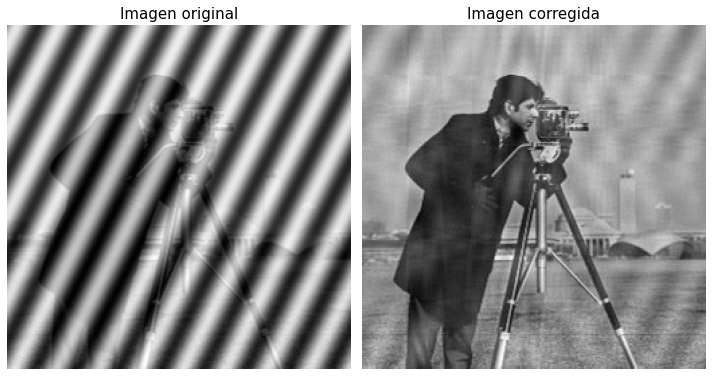

In [25]:
IIm_log_scaled = load_image(magnitude_file, 255)
IIp_scaled = load_image(phase_file, 255)

IIp = (IIp_scaled * (2*np.pi) / 255.0) - np.pi

IIm_log_max = np.log10(alpha + beta)
IIm_log = IIm_log_scaled * (IIm_log_max / 255.0)
IIm = ilog_transform(IIm_log, alpha, beta)

img_back = img_ifftShift(IIm, IIp, IIm_log_scaled.shape)


fig, axs = plt.subplots(1, 2, figsize=(10,10))

axs[0].imshow(img_gray, 'gray')
axs[0].set_title('Imagen original', size=15)
axs[0].set_axis_off()

axs[1].imshow(img_back, 'gray')
axs[1].set_title('Imagen corregida', size=15)
axs[1].set_axis_off()

plt.tight_layout()
plt.show()